In [482]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import njit
from matplotlib.animation import FuncAnimation

In [605]:
##### SIMULATION SETTINGS ######

# N x N grid
N = 200
#USE 2x THIS FOR FINAL

# Time between frames (in seconds)
dt = 0.01
# Number of discrete time steps
N_time_steps = 300

# Number of iterations for the Gauss-Seidel Solver in Diffuse and Advect stages
# Larger values results in marginally more accurate results 
lin_solve_iter = 20

##### FLUID SETTINGS ######

diff = 100000
visc = 0.3

# Controls the % of liquid removed per iterations
# Larger values => more liquid removed
# Domain is [0, 1], 0 = no liquid removed
constraint_constant = 0
# Warning: Values too high are not recommended because it will leave too little fluid left.

# List all fluid sources you would like to include
# Each source is a dictionary, please use the same syntax and same keys () as the example.
# Each dictionary and the next should be separated by a comma like in the example

# For each source, the grid cell (y_idx, x_idx) will emit fluid with specified x velocity, y velocity, and emission rate
sources = [
    
    {
        'emission density': 1,
        
        'y location (y_idx)': N,
        'x location (x_idx)': N//2,
        
        'y velocity': 1e3,
        'x velocity': 0
    }
    
]

# Warning: Too High Velocity and too many sources super close to one another can cause unexpected / divergent behavior

# Note 1: For larger N, adding more sources is recommended so there is enough fluid inflow
# Note 2: x in interval [1, N], y in interval [1, N]
# Note 3: that (0,0) is the upper left cell. So to convert traditional (x,y) coordinates to grid indicies: (x, N+1-y) = (x_idx, y_idx)
# Note 4: x and y velocities are coefficients proportional to the actual units/seconds velocity
# Note 5: Emission density are relative

##### ANIMATION SETTINGS ######

# loc = "Demos/"
loc = ""
name = "asdfasdfa"

# NOTE: If you are experiencing a weird color flickering effect (dimmer/brighter each frame), make this value larger (try x2, x5, etc.)
color_correction_coef = 0.0005

#Color Map used for display
cmap = "viridis"
#Select from following list: 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

# Set to false if you don't want to include the vector field plot in the video
showVectorField = False

#multiplier for how fast animation should be
animation_speed = 1

# vector sizes in final display are scaled by this constant, larger values -> smaller vector magnitudes
vscale = 4
# color of vectors in final display
vcolor = 'b'

# Dots per inches / image "resolution"
# Larger value => less blurry animation
dpi = 300

print("Final video will be " + str(dt * N_time_steps / animation_speed) + " seconds long with " + str(1/dt*animation_speed) + " fps.")

#How long will everything take?

Final video will be 3.0 seconds long with 100.0 fps.


In [606]:
# full - reflect
# lr - copy top and bottom, reflect others
# ud - copy left and right, reflect others

@njit(fastmath=True)
def set_bnd(b, X):
    for i in range(1, N+1):
        X[0][i] = -X[1][i] if b == "ud" else X[1][i]
        X[N+1][i] = -X[N][i] if b == "ud" else X[N][i]
        
        X[i][0] = -X[i][1] if b == "lr" else X[i][1]
        X[i][N+1] = -X[i][N] if b == "lr" else X[i][N]
    
    #do corners - average of 2 around
    X[0][0] = (X[1][0] + X[0][1]) * 0.5
    X[0][N+1] = (X[1][N+1] + X[0][N]) * 0.5
    X[N+1][0] = (X[N][0] + X[N+1][1]) * 0.5
    X[N+1][N+1] = (X[N][N+1] + X[N+1][N]) * 0.5
    
@njit(fastmath=True)
def addSource(i, j, X, x):
    X[i][j] += dt * x
    
# Diffuse backwards in time: x0[IX(i,j)] = x[IX(i,j)] - a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)] -4*x[IX(i,j)]);
# ==> ( x0[IX(i,j)] + a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)]) ) / ( 1 + 4*a )

@njit(fastmath=True)
def diffuse(X, X0, coef, b = "full", n_iter = lin_solve_iter):
        # Gauss-Seidel: observation - very few non-zero values in matrix & strictly diagonally dominant
        # start with incorrect values, solve by iteratively calculating assuming incorrect values are correct, then setting result as the new incorrect value
        a = dt * coef * N * N

        for k in range(n_iter):
            for i in range(1, N+1):
                for j in range(1, N+1):
                    X[i][j] = (X0[i][j] + a*(X[i-1][j] + X[i][j-1] + X[i][j+1] + X[i+1][j]))/(1+4*a)
            # what to do when collision with boundary
            set_bnd(b, X)

# linear interpolation, loc x in length 1, a to b
@njit(fastmath=True)
def lerp(a, b, x):
    slope = b - a
    return a + slope * x
    
# advect backwards (start from center and go back), using next velocity to linear interpolate, to find density contributions
# Note: may need coefficient for multiplier ==> mult changes with dt?
@njit(fastmath=True)
def advect(X, X0, u, v, b = "full"):
    for i in range(1, N+1):
        for j in range(1, N+1):
            y = i - dt * N * v[i][j]
            x = j - dt * N * u[i][j]
            x = max(x, 0.5)
            x = min(x, N+0.5)
            y = max(y, 0.5)
            y = min(y, N+0.5)
            
            frac_y = y - math.floor(y)
            frac_x = x - math.floor(x)

            y = math.floor(y)
            x = math.floor(x)
            
            #first interpolate looking through the x dimension
            x0 = lerp(X0[y][x], X0[y][x+1], frac_x)
            x1 = lerp(X0[y+1][x], X0[y+1][x+1], frac_x)
            
            #then interpolate looking through x dimension
            res = lerp(x0, x1, frac_y)
            X[i][j] += res

    set_bnd(b, X)
    
# By helmholtz's theorem, every velocity field is the addition of a curl-free and divergence-free vector field. In this function, we compute the divergence-free field by computing curl-free and subtracting it from original
@njit(fastmath=True)
def project(u, v, p, div, n_iter=lin_solve_iter):
    for i in range(1, N+1):
        for j in range(1, N+1):
            div[i][j] = -0.5 * (u[i][j+1] - u[i][j-1] + v[i+1][j] - v[i-1][j]) / N
            p[i][j] = 0
    
    set_bnd("full", div)
    set_bnd("full", p)
    
    for k in range(n_iter):
        for i in range(1, N+1):
            for j in range(1, N+1):
                p[i][j] = (div[i][j] + p[i-1][j] + p[i+1][j] + p[i][j-1] + p[i][j+1]) / 4
        set_bnd("full", p)
    
    for i in range(1, N+1):
        for j in range(1, N+1):
            u[i][j] -= 0.5 * (p[i][j+1] - p[i][j-1]) * N
            v[i][j] -= 0.5 * (p[i+1][j] - p[i-1][j]) * N
            
    set_bnd("lr", u)
    set_bnd("ud", v)
    
'''
To calculate the curl-free field of a given vector field using Poisson equations, you can use the following steps:

Define your vector field as a function of the coordinates of the grid points. Let's call this vector field V(x,y,z), where x,y,z are the coordinates of a given grid point.

Calculate the curl of the vector field using the curl operator: curl(V) = (dVz/dy - dVy/dz, dVx/dz - dVz/dx, dVy/dx - dVx/dy). This will give you a new vector field that represents the direction and magnitude of the curl of the original vector field at each grid point.

Use the Poisson equation to find a scalar potential function φ(x,y,z) that satisfies the equation ∇²φ = -div(curl(V)), where ∇² is the Laplace operator and div is the divergence operator. This scalar potential function will represent the curl-free component of the original vector field.

Calculate the gradient of the scalar potential function using the gradient operator: grad(φ) = (∂φ/∂x, ∂φ/∂y, ∂φ/∂z). This will give you a new vector field that represents the direction and magnitude of the curl-free component of the original vector field at each grid point.

Subtract the curl-free vector field from the original vector field to get the remaining curl component: V_curl = V - grad(φ).

Following these steps should allow you to calculate the curl-free component of your vector field using Poisson equations. Note that the calculation of the scalar potential function φ can be done using various numerical methods such as finite difference, finite element, or spectral methods, depending on the specifics of your problem.
'''

"\nTo calculate the curl-free field of a given vector field using Poisson equations, you can use the following steps:\n\nDefine your vector field as a function of the coordinates of the grid points. Let's call this vector field V(x,y,z), where x,y,z are the coordinates of a given grid point.\n\nCalculate the curl of the vector field using the curl operator: curl(V) = (dVz/dy - dVy/dz, dVx/dz - dVz/dx, dVy/dx - dVx/dy). This will give you a new vector field that represents the direction and magnitude of the curl of the original vector field at each grid point.\n\nUse the Poisson equation to find a scalar potential function φ(x,y,z) that satisfies the equation ∇²φ = -div(curl(V)), where ∇² is the Laplace operator and div is the divergence operator. This scalar potential function will represent the curl-free component of the original vector field.\n\nCalculate the gradient of the scalar potential function using the gradient operator: grad(φ) = (∂φ/∂x, ∂φ/∂y, ∂φ/∂z). This will give you a n

In [607]:
import random

theta = random.random() * math.pi * 2
def rotate(speed = 2 * math.pi / 5):
    global theta
    theta += speed * dt
    
@njit(fastmath=True)
def vel_step(u, v, u0, v0):    
    diffuse (u, u0, visc, b="lr")
    diffuse (v, v0, visc, b="ud")
    
    # project first because advect works better with a divergence-free v-field
    project(u0, v0, u, v)
        
    advect (u, u0, u0, v0, b="lr")
    advect (v, v0, u0, v0, b="ud")
    
    project(u, v, u0, v0)
    
@njit(fastmath=True)
def dens_step(dens, dens0, u, v):    
    diffuse (dens, dens0, diff)
    advect (dens, dens0, u, v)
    
# Frame by frame, there are varying # of cells near the source with outlier densities that disportionately skews the data range
# This causing large differences in the normalization process for the colormap, causing a weird flickering color effect between frames
@njit(fastmath=True)
def removeExtremes(frame, N_sources, coef = color_correction_coef):
    temp = np.reshape(frame, (sz * sz))
    temp = np.sort(temp)
    
    mx_idx = sz * sz - 1 - N_sources * int(coef * sz * sz)

    for i in range(sz):
        for j in range(sz):                
            frame[i][j] = min(frame[i][j], temp[mx_idx])
    
    return frame

In [620]:
sources = []
# for i in range(1):
#     sources.append({
#         'emission rate': N,
        
#         'y location (y_idx)': N//2 - int(0.05*N/2) + i,
#         'x location (x_idx)': N//2,
        
#         'y velocity': 1e3,
#         'x velocity': 0
#     })
# diff=10

# sources.append({
#     'emission density': 1,

#     'y location (y_idx)': N,
#     'x location (x_idx)': N//2,

#     'y velocity': -1e3,
#     'x velocity': 0
# })

sources.append({
    'emission density': 1,

    'y location (y_idx)': 3,
    'x location (x_idx)': 3,

    'y velocity': math.sqrt(1e8),
    'x velocity': math.sqrt(1e8)
})

sources.append({
    'emission density': 1,

    'y location (y_idx)': 3,
    'x location (x_idx)': N-2,

    'y velocity': math.sqrt(1e8),
    'x velocity': -math.sqrt(1e8)
})

sources.append({
    'emission density': 1,

    'y location (y_idx)': N-2,
    'x location (x_idx)': 3,

    'y velocity': -math.sqrt(1e8),
    'x velocity': math.sqrt(1e8)
})

sources.append({
    'emission density': 1,

    'y location (y_idx)': N-2,
    'x location (x_idx)': N-2,

    'y velocity': -math.sqrt(1e8),
    'x velocity': -math.sqrt(1e8)
})

# sources.append({
#     'emission density': 1,

#     'y location (y_idx)': 1,
#     'x location (x_idx)': N//2,

#     'y velocity': 1e3,
#     'x velocity': 0
# })

# sources.append({
#     'emission density': 1,

#     'y location (y_idx)': N//2,
#     'x location (x_idx)': N//2,

#     'y velocity': 1e3,
#     'x velocity': 0
# })

print(N, len(sources))

200 4


In [621]:
%%time

from tqdm import tqdm

sz = N+2

animation_frames = []
u_frames = []
v_frames = []

dens0 = np.zeros((sz, sz))
# v is y direction velocity ~ j
v0 = np.zeros((sz, sz))
# u is x direction velocity ~ i
u0 = np.zeros((sz, sz))

# theta = 0
# gravity = 9.81

for i in tqdm(range(N_time_steps), position=0, leave=True):
    dens = np.zeros((sz, sz))
    u = np.zeros((sz, sz))
    v = np.zeros((sz, sz))

#     addSource (sz//2, sz//2, u0, dt * N * 1e4)
#     addSource(sz//2, sz//2, dens0, 1)

    # Uncomment this bit out to add gravity/acceleration (also uncomment gravity out from above, and change it as desired)
#     v0 -= gravity * dt / 60
        
#.    Uncomment this bit out to add rotation (Also uncomment theta out from above)
#     theta += math.pi * dt / 2
#     for j in range(len(sources)):        
#         sources[j]['x velocity'] = math.cos(theta) * 1e2 * 5
#         sources[j]['y velocity'] = math.sin(theta) * 1e2 * 5
    
    for source in sources:
        e, y_idx, x_idx, y_v, x_v = list(source.values())
        
#         if dt * i < 6:
        addSource (y_idx, x_idx, v0, dt * N * y_v)
        addSource (y_idx, x_idx, u0, dt * N * x_v)
        addSource(y_idx, x_idx, dens0, e)
#         print(u0[1][1]/v0[1][1])
    
    
    vel_step (u, v, u0, v0)
    dens_step(dens, dens0, u, v)
    
    animation_frames.append(removeExtremes(dens.copy(), len(sources)))
    u_frames.append(u.copy())
    v_frames.append(v.copy())
    
    dens *= 1 - constraint_constant
    
    dens0 = dens
    v0 = v
    u0 = u
    
# 10 => 100
# 200 => 2000

100%|██████████| 300/300 [00:10<00:00, 29.96it/s]

CPU times: user 9.89 s, sys: 129 ms, total: 10 s
Wall time: 10 s


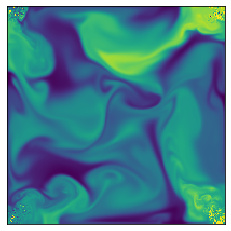

In [622]:
# This cell is purely for testing, it plots frame by frame with reasonable pause bedisregarding dt
import time
from IPython.display import clear_output
import matplotlib

for i in range(N_time_steps):
    plt.close()
    clear_output(wait=True)
    
    if showVectorField:
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        ax2.invert_yaxis()
        fig.tight_layout()

        ax1.matshow(animation_frames[i], cmap=cmap, aspect="auto")
        ax2.quiver(u_frames[i], v_frames[i], color=vcolor, pivot='mid', units='xy', scale=vscale)
    else:
        fig, ax = plt.subplots(1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.matshow(animation_frames[i], cmap=cmap)
        
    plt.show()
#     time.sleep(dt)

# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

100%|█████████▉| 1199/1200 [00:48<00:00, 24.48it/s]

CPU times: user 45.1 s, sys: 1.7 s, total: 46.8 s
Wall time: 49.2 s


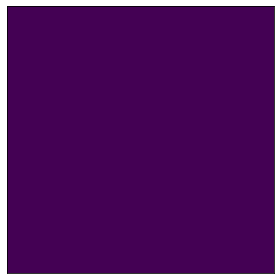

100%|█████████▉| 1199/1200 [01:00<00:00, 24.48it/s]

In [479]:
%%time

#COMMENT THE BELOW LINE OUT IN FINAL OUTPUT
# matplotlib.use("Agg")
name='test'
# name += " fps " + str(1/dt*animation_speed) + '-' + str(N) + "x" + str(N) + "-" + str(diff) + "-" + str(visc)

Writer = animation.writers['ffmpeg']
# NOTE: This works for QuickTime Player on Mac, YOU MAY HAVE TO CHANGE extra_args SECTION IF U R USING SMTH DIFFERENT
writer = Writer(extra_args=['-pix_fmt', 'yuv420p'], fps=1/dt*animation_speed)

#Make plot
if showVectorField:
    fig, (ax1, ax2) = plt.subplots(1, 2)
else:
    fig, ax1 = plt.subplots(1)
    
# Change plot settings
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
fig.tight_layout()

if showVectorField:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.invert_yaxis()

# Plot the first frame 
fluid = ax1.imshow(animation_frames[0], animated=True, cmap=cmap, aspect = ("auto" if showVectorField else None))

if showVectorField:
    vfield = ax2.quiver(u_frames[0], v_frames[0], animated=True, color=vcolor, pivot='mid', units='xy', scale=vscale)

def updatefig(idx, fluid, vfield):
    # DONT USE AUTO SCALE TO REMOVE FLICKIENRG ==> SET VMAX TO EXCLUDE THE SOURCES
    fluid.autoscale()
    fluid.set_data(animation_frames[idx])
    if showVectorField:
        vfield.set_UVC(u_frames[idx], v_frames[idx])
                
    return fluid, vfield

# FIX ANIMATION SPEED
ani = FuncAnimation(fig, updatefig, frames=tqdm(range(len(animation_frames)), position=0, leave=True), fargs=(fluid, (vfield if showVectorField else None)), blit=False)

ani.save(loc + name + ".mp4", dpi=dpi, writer=writer)

In [ ]:
```
= Add a cell for user interactivity in jupyter
= see change if each variable is changed incrementally (e.g, from no velocity to high velocity)
TO-DO Demos:
    - Gravity => OK
    - Changing Gravities => ok
    - Multiple shooting at each other (4, corners)
    - wind tunnel => ok
    - Torus
    - Moving sources (in one direction)
    - Zero at all boundaries
    - At some point stop releasing fluid
    - rotating fluid shooting
    - Circle around the frame (velocity field)
```